### Task 5

You have an image patch of size (50x50) that you want to compress using matrix factorization. To do this, you'll split the patch \([N \times N]\) into two smaller matrices of size \([N \times r]\) and \([r \times N]\) using matrix factorization. Compute the compressed patch by multiplying these two matrices and compare the reconstructed image patch with the original patch. Compute the Root Mean Squared Error (RMSE) and Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed image patches.

- Test different values for the low-rank \(r = [5, 10, 25, 50]\).
- Use Gradient Descent to learn the compressed matrices.
- Display the reconstructed image patches, keeping the original pixel values outside the patch unchanged, and use your compressed matrix for the patch to show how well the reconstruction works.
- Compute the RMSE and PSNR for each value of \(r\).


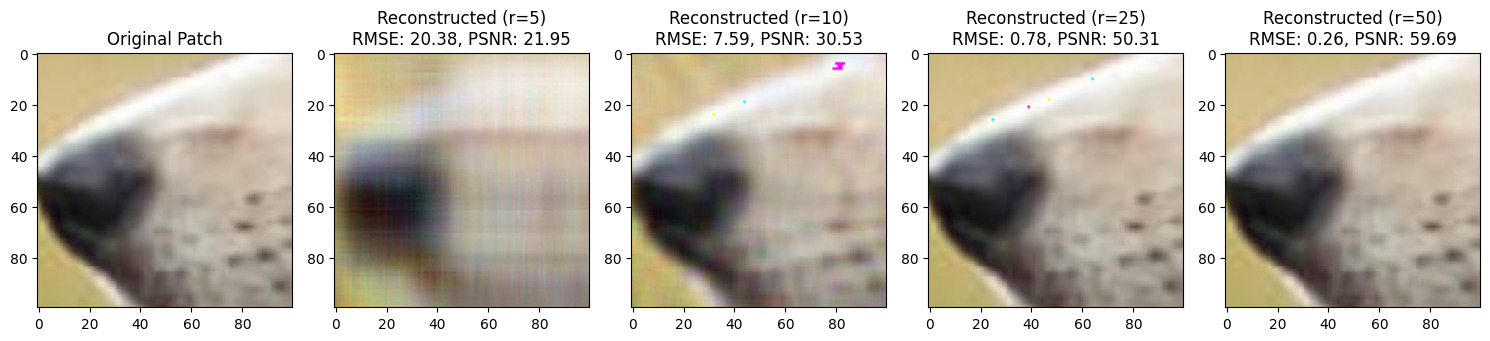

         RMSE       PSNR
5   20.376099  21.948383
10   7.590792  30.525063
25   0.777916  50.312141
50   0.264251  59.690479


In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import pandas as pd

img_path = r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 2\sample_images\multiple_colours.jpg'
img = Image.open(img_path)

img_np = np.array(img)

patch_size = 50
patch = img_np[200:250+patch_size, 75:125+patch_size, :]

def rmse(og, rec):
    return np.sqrt(np.mean((og - rec) ** 2))

def psnr(og, rec):
    mse = np.mean((og - rec) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

def matrix_factorization(patch, r, alpha, epochs):
    A = torch.tensor(patch, dtype=torch.float32)
    N = A.shape[0]
    
    W = [torch.randn(N, r, requires_grad=True) for _ in range(3)]
    H = [torch.randn(r, N, requires_grad=True) for _ in range(3)]
    
    optimizer = optim.Adam(W + H, lr=alpha)
    
    for i in range(epochs):
        optimizer.zero_grad()
        rec = torch.stack([torch.mm(W[i], H[i]) for i in range(3)], dim=2) #multiply
        loss = torch.norm(A - rec)
        loss.backward() #grad
        optimizer.step() #update
    
    with torch.no_grad(): #training done. Dont track
        rec = torch.stack([torch.mm(W[i], H[i]) for i in range(3)], dim=2) #reconstruct with final values of W nd H
    return rec.numpy()

r_values = [5, 10, 25, 50]
results = {}

for r in r_values:
    rec = matrix_factorization(patch, r , 0.001 , 10000)
    rmse_f = rmse(patch, rec)
    psnr_f = psnr(patch, rec)
    results[r] = {'reconstructed_patch': rec, 'RMSE': rmse_f, 'PSNR': psnr_f}

fig, axes = plt.subplots(1, len(r_values)+1, figsize=(15, 5))

axes[0].imshow(patch.astype(np.uint8))
axes[0].set_title('Original Patch')



for i, r in enumerate(r_values):
    axes[i+1].imshow(results[r]['reconstructed_patch'].astype(np.uint8))
    axes[i+1].set_title(f'Reconstructed (r={r})\nRMSE: {results[r]["RMSE"]:.2f}, PSNR: {results[r]["PSNR"]:.2f}')

plt.tight_layout()
plt.show()

df_results = pd.DataFrame(results).T[['RMSE', 'PSNR']]
print(df_results)
